* https://gist.github.com/AustinRochford/afe6862e622c31494b2f
* https://stackoverflow.com/questions/22015055/survival-analysis-in-pymc-3

In [393]:
%matplotlib inline

In [394]:
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk
import seaborn as sns
import pandas as pd
from theano import tensor as T

In [395]:
np.random.negative_binomial(2, 0.05, N_low)

array([ 49,   2,  22, 125,  43,  65,  75,  18,  27,  10,  58,  20,  46,
         1,  21,  67,  45,  66,  85,  18,   9,  34,   2,  21,  49,  12,
        82,  84,  47,  26,  11,  21,  45,  22,  10,  18,  60,  12,  11,
        53,  68,  66,  31,  19,  49,  40,  44,  27,  41,  98,   9,   7,
        11,  30,  28,  27,  97,  60,  34,  51,  57,  16,  14,  16,  69,
        36,  20,  35,  17,  54,  34,  55,  29,  49,  32,  29,  83,  19,
         8,  21,  23,  37,  65, 191,  22,  88,  26, 162,  29, 126,  12,
        22,  44,  43,  26,  44,  14,  18,  18,  23,  32, 116,  34,  32,
        13,  20,  39,  53,  38,  11,  21,  72,   7,  70,  38,  38,  62,
        34,   7, 100,  34,  70,  31,  28,  20,  76,  19,  27,  23,  32,
         9,  79,  25,  98,  25,  63,  43,  32,  13, 116,  11,  13,  50,
        48,  35,  65,  35,  57,  51,  64,  51,   0,  88,  35,  89,  14,
        15,  92,  92,  29,  13,  42,  39,  36,  19,  43,  96,  16,   4,
        29,  14,  68,  39,  13,  68,   3,  16,  87,  24,  82,  4

In [396]:
N = 300

np.sum(np.random.binomial(1, 0.3, 100))
N_low = int(N*np.sum(np.random.binomial(1, 0.7, 100))/100)

#rand_curve = 60*np.sort(np.random.exponential(scale=0.5, size=N_low))
rand_curve = np.random.poisson(15, int(0.3*N_low))#
rand_curve = np.concatenate((rand_curve,np.random.poisson(30, int(0.4*N_low))))
rand_curve = np.concatenate((rand_curve,np.random.poisson(40, int(0.3*N_low))))

#rand_curve = np.random.negative_binomial(2, 0.05, N_low)
inital_time = np.round(rand_curve, 0).astype(int)
assessment = np.random.binomial(1, 0.8, len(rand_curve))

PIA_low = pd.DataFrame({'time':inital_time,'assessment':assessment,'acuity':0})

N_high = N-N_low
rand_curve = np.random.poisson(15, N_high)
inital_time = np.round(rand_curve, 0).astype(int)
assessment = np.random.binomial(1, 0.9, N_high)

PIA_high = pd.DataFrame({'time':inital_time,'assessment':assessment,'acuity':1})

df = pd.concat([PIA_low, PIA_high], axis=0)
df.head()

n_patients = df.shape[0]
patients = np.arange(n_patients)

len(df[df['acuity']==0])

184

In [397]:
#df = pd.read_csv('../data/mastectomy.csv')
#df = df.assign(event = np.array(df['event'].values == True).astype(int))
#df = df.assign(metastized = np.array(df['metastized'].values == 'yes').astype(int))
#n_patients = df.shape[0]
#patients = np.arange(n_patients)
#df.columns = ['time','assessment','acuity']
#df.tail()

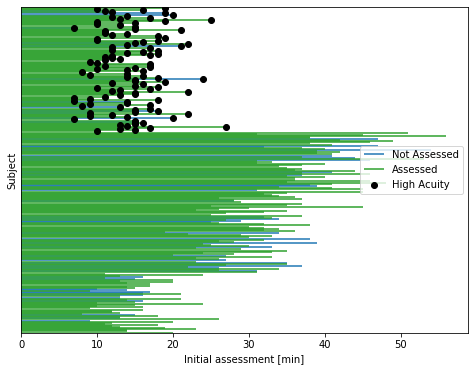

In [398]:
fig, ax = plt.subplots(figsize=(8, 6))

blue, _, red = sns.color_palette()[:3]

ax.hlines(patients[df.assessment.values == 0], 0, df[df.assessment.values == 0].time,
          color=blue, label='Not Assessed')

ax.hlines(patients[df.assessment.values == 1], 0, df[df.assessment.values == 1].time,
          color=red, label='Assessed')

ax.scatter(df[df.acuity.values == 1].time, patients[df.acuity.values == 1],
           color='k', zorder=10, label='High Acuity')

ax.set_xlim(left=0)
ax.set_xlabel('Initial assessment [min]')
ax.set_yticks([])
ax.set_ylabel('Subject')

ax.set_ylim(-0.25, n_patients + 0.25)

ax.legend(loc='center right');

In [399]:
interval_length = 3
interval_bounds = np.arange(0, df.time.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

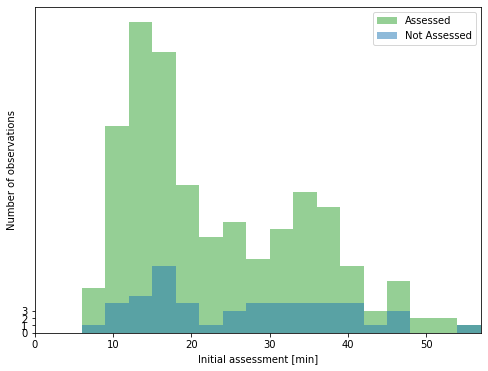

In [400]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(df[df.assessment == 1].time.values, bins=interval_bounds, color=red, alpha=0.5, lw=0, label='Assessed');
ax.hist(df[df.assessment == 0].time.values, bins=interval_bounds, color=blue, alpha=0.5, lw=0, label='Not Assessed');

ax.set_xlim(0, interval_bounds[-1]);
ax.set_xlabel('Initial assessment [min]');

ax.set_yticks([0, 1, 2, 3]);
ax.set_ylabel('Number of observations');

ax.legend();

In [401]:
last_period = np.floor((df.time - 0.01) / interval_length).astype(int)

assessed = np.zeros((n_patients, n_intervals))
assessed[patients, last_period] = df.assessment

In [402]:
exposure = np.greater_equal.outer(df.time.values, interval_bounds[:-1]) * interval_length
exposure[patients, last_period] = df.time - interval_bounds[last_period]

In [403]:
SEED = 644567 # from random.org

In [404]:
with pm.Model() as model:

    lambda0 = pm.Gamma('lambda0', 0.01, 0.01, shape=n_intervals)

    beta = pm.Normal('beta', 0, sigma=100)

    lambda_ = pm.Deterministic('lambda_', T.outer(T.exp(beta * df.acuity), lambda0))
    mu = pm.Deterministic('mu', exposure * lambda_)

    obs = pm.Poisson('obs', mu, observed=assessed)

In [405]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step, progressbar=True )    

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [lambda0]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [406]:
base_hazard = trace['lambda0']
met_hazard = trace['lambda0'] * np.exp(np.atleast_2d(trace['beta']).T)

In [407]:
def cum_hazard(hazard):
    return (interval_length * hazard).cumsum(axis=-1)

def survival(hazard):
    return np.exp(-cum_hazard(hazard))

In [408]:
def plot_with_hpd(x, hazard, f, ax, color=None, label=None, alpha=0.01):
    mean = f(hazard.mean(axis=0))

    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(hazard), percentiles, axis=0)

    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.25)
    ax.step(x, mean, color=color, label=label);

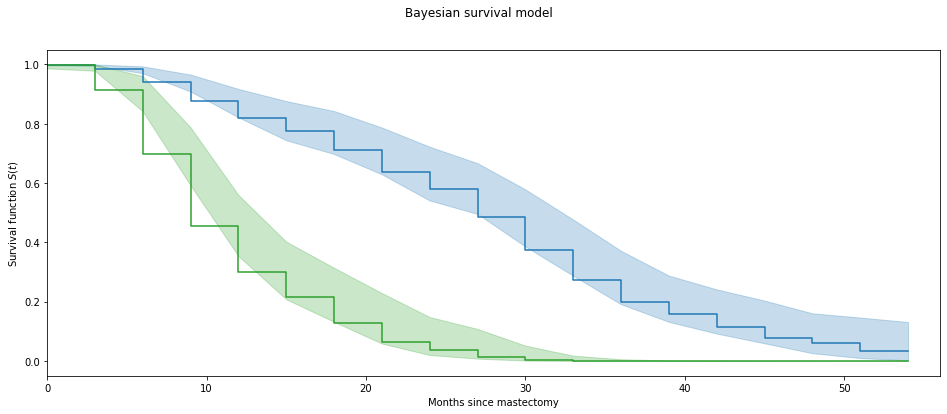

In [409]:
fig, (surv_ax) = plt.subplots(ncols=1, sharex=True, sharey=False, figsize=(16, 6))

plot_with_hpd(interval_bounds[:-1], base_hazard, survival, surv_ax, color=blue)
plot_with_hpd(interval_bounds[:-1], met_hazard, survival, surv_ax, color=red)

surv_ax.set_xlim(0, df.time.max());
surv_ax.set_xlabel('Months since mastectomy');

surv_ax.set_ylabel('Survival function $S(t)$');

fig.suptitle('Bayesian survival model');